In [1]:
# Import the needed Packages
# FMU Simulation
import MoBASimulator as mb
# Numpy
import numpy as np
# Bokeh for Plotting
#import bokeh.plotting as bk
#import bokeh.io as bi
#from bokeh.io import export_svgs
#bi.output_notebook()
# select a palette
#from bokeh.palettes import Spectral10  as palette
#from bokeh.models import Legend, LabelSet, Label, BoxAnnotation, LogTickFormatter
# Matplotlib for Plotting
import matplotlib.pyplot as plt

# Algorithms
import Algorithms as alg
from Algorithms import TUBScolorscale
from Algorithms import cm2in
# Make the relevant Inputs
export_folder = "../Latex/Graphics"
model_name = "Rosenbrock_Testing"

# Plot width and heigth in cm
plot_width = 19.
plot_height = 7.5

# Simulation Parameter
hmax = .3

# Model Parameter
#k = np.random.uniform(-10,10,(2,2))
#t = np.random.uniform(1,20,(2,2))
#l = np.random.uniform(10,20,(2,2))

# Rosenbrock
k = [[1.,2./3.],[1.,1.]]
t = [[1.,1./3.],[1.,1.]]
l = [[1e-10,1e-10],[1e-10,1e-10]]

# Woodberry
#k = [[12.8,-18.9],[6.6,-19.4]]
#t = [[16.7,21.0],[10.9,14.4]]
#l = [[1,3],[7,3]]


# The needed Parameter
K = np.zeros((2,2))
T = np.zeros((2,2))
L = np.zeros((2,2))

# Load a Model
sim = mb.Simulator()
sim.clear()
sim.loadModel("C:/Users/juliu/Documents/Thesis/Modelica/FMU/2_2/Masterthesis_Models_mimo_0processmodel.fmu")
sim.setOperationMode('FMU for ModelExchange')

# Show log window
sim.showLogWindow()

# Parameter Values
params = {}
# Loop over system size
for outputs in range(1,3):
    for inputs in range(1,3):
        # Process Parameter 
        # System Gain
        params.update({"fmu.num["+str(outputs)+","+str(inputs)+",1]": k[outputs-1][inputs-1]})
        # System Lag
        params.update({"fmu.den["+str(outputs)+","+str(inputs)+",1]": t[outputs-1][inputs-1]})
        params.update({"fmu.den["+str(outputs)+","+str(inputs)+",2]": 1})
        # System Delay
        params.update({"fmu.delay["+str(outputs)+","+str(inputs)+"]": l[outputs-1][inputs-1]})

# Set Parameter and show for checking
sim.set(params)
#sim.showParameterDialog()
#print(params)

# Get the state space
ss = sim.analyser_getStateSpaceForm()



# First run, Input 1 -> Output 1 & 2
sim.set({"fmu.u[1]": 1,"fmu.u[2]": 0})
# Set timestep = 1e-2, endtime = 100
sim.resetModelState()
res = sim.simulate(0.01, 40)

# Get the signals
y = res["fmu.y[1]"]
y2 = res["fmu.y[2]"]
u = res["fmu.u[1]"]
time = res["time"]

# Get TF from Input 1 to Output 1
K[0][0],T[0][0],L[0][0]=alg.Integral_Identification(y,u,time)
# Get TF from Input 1 to Output 2
K[1][0],T[1][0],L[1][0]=alg.Integral_Identification(y2,u,time)


# Second run, Input 2 -> Output 1 & 2
# Reload the Model to set everything to zero
sim.resetModelState()
sim.set({"fmu.u[1]":0, "fmu.u[2]":1})
# Set timestep = 1e-2, endtime = 100
res=sim.simulate(0.01, 80)

# Get the signals
y = res["fmu.y[1]"]
y2 = res["fmu.y[2]"]
u = res["fmu.u[2]"]
time = res["time"]

# Get TF from Input 2 to Output 1
K[0][1],T[0][1],L[0][1] = alg.Integral_Identification(y,u,time)
# Get TF from Input 2 to Output 2
K[1][1],T[1][1],L[1][1] = alg.Integral_Identification(y2,u,time)

In [2]:
# Make variable storage
y = []
u = []
time = []

# Loop over the methods for controller design
for methods in range(0,3):
    if methods == 0:
        # Make a decentralized controller
        KY,B,D = alg.Control_Decentral(K,T,L)
        print("RGA")
        print(KY,B,D)
    elif methods == 1:
        # Make a decoupled controller with Astrom
        KY,B,D = alg.Control_Astrom(K,T,L,hmax*np.eye(2,2))
        print("Aström")
        print(KY,B,D)
    else:
        # Make a decoupled controller with modified Astrom
        KY,B,D = alg.Control_Decoupled(K,T,L,hmax*np.eye(2,2))
        print("R2D2")
        print(KY,B,D)

    # Make zeros to 1e-10 for numerical stable process
    KY[KY==0] = 1e-10
    B[B==0] = 1e-10
    D[D==0] = 1e-10


    # Load the closed loop model
    sim.clear()
    sim.loadModel("C:/Users/juliu/Documents/Thesis/Modelica/FMU/2_2/Masterthesis_Models_mimo_0closedloop.fmu")
    # Parameter Valuess
    params = {}
    
    # Loop over system size
    for outputs in range(1,3):
        for inputs in range(1,3):
            # Controller Parameter 
            # Proportional Gain
            params.update({"fmu.kp["+str(outputs)+","+str(inputs)+"]": KY[outputs-1][inputs-1][0]})
             # Integral Gain
            params.update({"fmu.ki["+str(outputs)+","+str(inputs)+"]": KY[outputs-1][inputs-1][1]})
            # Decoupler
            params.update({"fmu.d["+str(outputs)+","+str(inputs)+"]": D[outputs-1][inputs-1]})
            # Set Point Weight
            params.update({"fmu.b["+str(outputs)+","+str(inputs)+"]": B[outputs-1][inputs-1]})
            # Process Parameter 
            # Process Parameter 
            # System Gain
            params.update({"fmu.num["+str(outputs)+","+str(inputs)+",1]": k[outputs-1][inputs-1]})
            # System Lag
            params.update({"fmu.den["+str(outputs)+","+str(inputs)+",1]": t[outputs-1][inputs-1]})
            params.update({"fmu.den["+str(outputs)+","+str(inputs)+",2]": 1})
            # System Delay
            params.update({"fmu.delay["+str(outputs)+","+str(inputs)+"]": l[outputs-1][inputs-1]})

    # Set Parameter Values
    sim.set(params)
    
    # First run, Input 1 -> Output 1 & 2
    sim.resetModelState()
    sim.set({"fmu.u[1]": 1.,"fmu.u[2]": 0.})
    res=sim.simulate(0.1, 100)
    # Second run, Input 2-> Output 1 & 2
    sim.set({"fmu.u[1]": 1.,"fmu.u[2]": 1})
    res=sim.simulate(0.1, 200)

    # Store the output
    y.append([res["fmu.y[1]"],res["fmu.y[2]"]])
    u.append([res["fmu.u[1]"],res["fmu.u[2]"]])
    time.append([res["time"],res["time"]])

# Make Aström Reference from Paper
KY = np.array([ [[0.245, 0.248, 0], [0,0,0]], [[0,0,0], [-0.452,0.075,0]] ])
B = np.array([[0,0],[0,0]])
D = np.linalg.inv(k)

# Make zeros to 1e-10 for numerical stable process
KY[KY==0] = 1e-10
B[B==0] = 1e-10
D[D==0] = 1e-10


# Load the closed loop model
sim.clear()
sim.loadModel("C:/Users/juliu/Documents/Thesis/Modelica/FMU/2_2/Masterthesis_Models_mimo_0closedloop.fmu")
sim.reloadModel()
# Parameter Values
params = {}
# Loop over system size
for outputs in range(1,3):
    for inputs in range(1,3):
        # Controller Parameter 
        # Proportional Gain
        params.update({"fmu.kp["+str(outputs)+","+str(inputs)+"]": KY[outputs-1][inputs-1][0]})
         # Integral Gain
        params.update({"fmu.ki["+str(outputs)+","+str(inputs)+"]": KY[outputs-1][inputs-1][1]})
        # Decoupler
        params.update({"fmu.d["+str(outputs)+","+str(inputs)+"]": D[outputs-1][inputs-1]})
        # Set Point Weight
        params.update({"fmu.b["+str(outputs)+","+str(inputs)+"]": B[outputs-1][inputs-1]})
        # Process Parameter 
        # System Gain
        params.update({"fmu.num["+str(outputs)+","+str(inputs)+",1]": k[outputs-1][inputs-1]})
        # System Lag
        params.update({"fmu.den["+str(outputs)+","+str(inputs)+",1]": t[outputs-1][inputs-1]})
        params.update({"fmu.den["+str(outputs)+","+str(inputs)+",2]": 1})
        # System Delay
        params.update({"fmu.delay["+str(outputs)+","+str(inputs)+"]": l[outputs-1][inputs-1]})
# Set Parameter Values
sim.set(params)
#sim.showParameterDialog()

# First run, t<40
sim.resetModelState()
sim.set({"fmu.u[1]": 1,"fmu.u[2]": 0})
res=sim.simulate(0.01, 100)
# t>=40
sim.set({"fmu.u[1]": 1,"fmu.u[2]": 1})
# Set timestep = 1e-2, endtime = 100
res=sim.simulate(0.01, 200)

RGA
(array([[[ 0.7249317 ,  1.02262263,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.7249505 ,  1.02262369,  0.        ]]]), array([[ 0.,  0.],
       [ 0.,  0.]]), array([[ 1.,  0.],
       [ 0.,  1.]]))
Aström Detuning Iterations:0
Aström Detuning Iterations:6
Aström
(array([[[  7.24950690e-001,   4.18526192e-001,   0.00000000e+000],
        [  6.45735815e-316,   1.90450449e-316,   6.45736052e-316]],

       [[  6.45736764e-316,   6.45730835e-316,   6.45737475e-316],
        [  3.85268520e-001,   7.40404438e-001,   0.00000000e+000]]]), array([[ 0.,  0.],
       [ 0.,  0.]]), array([[ 2.99999529, -2.00002148],
       [-3.00007307,  3.00007307]]))
Modified Detuning Iterationts 0
Modified Detuning Iterationts 6
R2D2
(array([[[ 0.7249317 ,  1.02262263,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.38526842,  0.7398914 ,  0.      

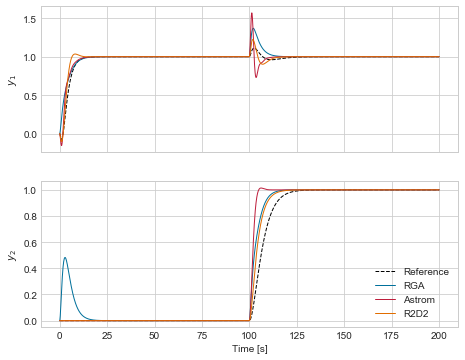

In [12]:
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(2, sharex=True,figsize = cm2in(plot_width,2.*plot_height))

ax[0].plot(res["time"],res["fmu.y[1]"], color = TUBScolorscale[0], linewidth = 1., linestyle = "dashed")
ax[0].plot(time[0][0],y[0][0], color = TUBScolorscale[9], linewidth = 1.)
ax[0].plot(time[1][0],y[1][0], color = TUBScolorscale[1], linewidth = 1.)
ax[0].plot(time[2][0],y[2][0], color = TUBScolorscale[3], linewidth = 1.)
ax[0].grid(True)
ax[0].set_ylabel('$y_1$')

ax[1].plot(res["time"],res["fmu.y[2]"], color = 'k', linewidth = 1., linestyle = "dashed", label="Reference")
ax[1].plot(time[0][1],y[0][1], color = TUBScolorscale[9], linewidth = 1., label="RGA")
ax[1].plot(time[1][1],y[1][1], color = TUBScolorscale[1], linewidth = 1., label="Astrom")
ax[1].plot(time[2][1],y[2][1], color = TUBScolorscale[3], linewidth = 1., label = "R2D2")
ax[1].grid(True)
ax[1].set_ylabel('$y_2$')
ax[1].set_xlabel('Time [s]')

plt.legend(loc="lower right")
plt.savefig(export_folder+model_name+".svg")
plt.show()

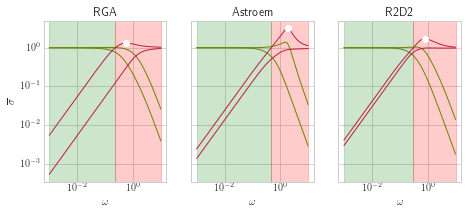

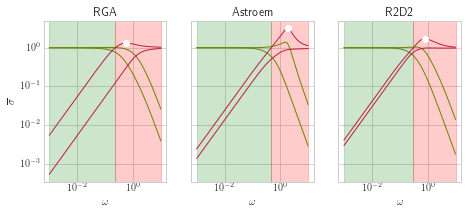

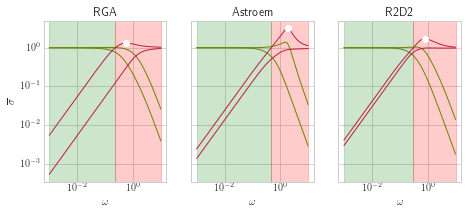

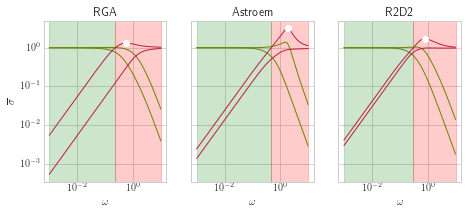

In [27]:
# -*- coding: utf-8 -*-
plt.style.use('seaborn-whitegrid')
plt.rc('text',usetex=True)
# Define Functions
S = lambda omega : alg.compute_sensitivity(ss,KY,B,D,omega)
CS = lambda omega : alg.compute_complementarysensitivity(ss,KY,B,D,omega)
sv = lambda X : np.linalg.svd(X, compute_uv = False)

fig, ax = plt.subplots(1,3, sharey=True, figsize=cm2in(plot_width,plot_height))

# Loop over the methods for controller design
for methods in range(0,3):
    if methods == 0:
        cur_method = "RGA"
        # Make a decentralized controller
        KY,B,D = alg.Control_Decentral(K,T,L)        
        ax[methods].set_ylabel('$\overline{\sigma}$')
    elif methods == 1:
        cur_method = "Astroem"
        # Make a decoupled controller with Astrom
        KY,B,D = alg.Control_Astrom(K,T,L,hmax*np.eye(2,2))
        
        
    else:
        cur_method = "R2D2"
        # Make a decoupled controller with modified Astrom
        KY,B,D = alg.Control_Decoupled(K,T,L,hmax*np.eye(2,2))
        
        
        
    # Loop over Frequency
    w = np.logspace(-3,1, 1e4)
    SV = np.empty((2,len(w)))
    TV = np.empty((2,len(w)))
    for i in range(0,len(w)):
        freq = w[i]
        SV[:,i] = sv(S(freq))
        TV[:,i] = sv(CS(freq))
    # Find the maximum Singular Value
    max_sv = np.argmax(SV[0,:])
    w_max = w[max_sv]
    max_sv = SV[0,max_sv]
    
    # Find Robustness Area, Last Element less than one
    rob_sv = np.argmax(SV[0,:]>.99)
    w_rob = w[rob_sv]
    rob_sv= SV[0,rob_sv]
    
    # Make a Plot
    ax[methods].set_title(cur_method)
    ax[methods].axvspan(np.min(w),w_rob, color ='green', alpha =0.2)
    ax[methods].axvspan(w_rob,np.max(w), color ='red', alpha =0.2)
    
    ax[methods].loglog(w,TV[0,:], color=TUBScolorscale[6], label="$\ma{T}$", linewidth=1)
    ax[methods].loglog(w,TV[1,:], color=TUBScolorscale[6], linewidth=1)
    
    ax[methods].loglog(w,SV[0,:], color=TUBScolorscale[1], label="$\ma{S}$", linewidth=1)
    ax[methods].loglog(w,SV[1,:], color=TUBScolorscale[1], linewidth=1)
    
    
    ax[methods].loglog(w_max, max_sv,marker="o", color='w', label="$\overline{\sigma}$"+ "(%.2f, %.2f)" %(w_max ,max_sv))
    ax[methods].set_xlabel('$\omega$')
    ax[methods].grid(True)
    # Set the xticks and labels
    #ax[methods].set_xticks([1e-2,1e0])
    #ax[methods].set_xticklabels([r'$10^{-2}$', r'$10^0$'])
    
plt.savefig(export_folder+model_name+"_SV.svg")    
plt.show()

In [21]:
# Get the step_info and the Disturbance Info
# Define Method Name
cur_methods = ['RGA', 'Astroem', 'R2D2']
cur_ouput = ['$y_1$','$y_2$']
steptime = 100
# Make structure for storage
File = open(export_folder+model_name+"_StepInfo.tex","w")
# Add the header
File.write('\\begin{tabular}{l|c| c|c|c|| c|c|c|} \n ')
File.write('\\multicolumn{2}{l}{\multirow{3}{*}}  &  \\multicolumn{3}{c}{Tracking Performance} & \\multicolumn{3}{l}{Rejection Performance}  \\\ \\cline{3-8} \n')
File.write('\\multicolumn{2}{l|}{}  & $T_{Rise}$ & $m_P$ & $T_{Settle}$ & $T_{p}$ & $m_{\Delta}$ & $T_{Settle}$  \\\ \\cline{3-8} \n')
File.write('\multicolumn{2}{l|}{} & s         & \%        & s  & s         & \%        & s             \\\ \\hline \\hline \n')
for methods in range(0,3):
    for outputs in range(0,2):
        # Get the current Output
        y1 = y[methods][outputs]
        t1 = time[methods][outputs]
        y2 = y[methods][1-outputs]
        t2 = time[methods][1-outputs]
        # Write to File
        if outputs == 0:
            # Get the StepInfo
            tr, mp, ts, ys = alg.Step_Info(y1[np.where(t1<steptime)],t1[np.where(t1<steptime)])
            trd, mpd, tsd, ysd = alg.Disturbance_Info(y2[np.where(t1<steptime)],t2[np.where(t1<steptime)])  
            File.write(' & '+cur_ouput[outputs]+'& %.2f & %.2f & %.2f & %.2f & %.2f & %.2f\\\ \\cline{2-8} \n'%(tr,mp,ts, trd, mpd, tsd))
        else:
            # Get the StepInfo
            tr, mp, ts, ys = alg.Step_Info(y1[np.where(t1>steptime)],t1[np.where(t1>steptime)])
            trd, mpd, tsd, ysd = alg.Disturbance_Info(y2[np.where(t1>steptime)],t2[np.where(t1>steptime)])
            alg.Disturbance_Info(y1[np.where(t1<steptime)],t1[np.where(t1<steptime)])
            File.write('\\multirow{-2}{*}{'+cur_methods[methods]+'} & '+cur_ouput[outputs]+'& %.2f & %.2f & %.2f & %.2f& %.2f& %.2f\\\ \\hline \\hline\n'%(tr,mp,ts, trd, mpd, tsd))
File.write('\\end{tabular}')
File.close()

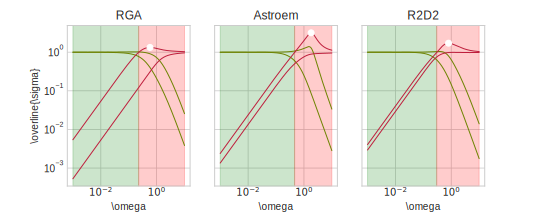

In [23]:
from IPython.display import SVG
SVG(export_folder+model_name+"_SV.svg")

# BOKEH
#Make Plot
    p = bk.figure(title = cur_method, 
              width = plot_height, height = plot_height,
              x_axis_type ="log", y_axis_type = "log",
             x_axis_label = "Frequency [rad/s]", y_axis_label = "Gain")
    # Robustness Area
    p.add_layout(BoxAnnotation(right = w_rob, fill_alpha=0.1, fill_color='green'))
    p.add_layout(BoxAnnotation(left = w_rob, fill_alpha=0.1, fill_color='red'))
    # Sensitivity
    p.line(w,SV[0,:], color = TUBScolorscale[0], legend="$\ma{S}$")
    p.line(w,SV[1,:], color = TUBScolorscale[0])
    # Complementary Sensitivity
    p.line(w,TV[0,:], color = TUBScolorscale[6], legend= "$\ma{T}$")
    p.line(w,TV[1,:], color = TUBScolorscale[6])
    
    # Maximum Sensitivity
    p.scatter(w_max, max_sv,size = 10, line_color = TUBScolorscale[0], fill_color = "white", legend="$\overline{\sigma}$ "+"(%.2f, %.2f)" %(w_max ,max_sv))
    
    # Format
    p.xaxis.formatter = LogTickFormatter()
    p.xaxis.axis_label_text_font_size = "10pt"
    p.yaxis.axis_label_text_font_size = "10pt"
    p.toolbar.logo = None
    p.toolbar_location = None
    p.legend.visible = False
    p.legend.location = "bottom_left"
    bk.show(p)
    p.output_backend = "svg"
    export_svgs(p, export_folder+model_name+cur_method+"_SV.svg")
    bk.reset_output

from bokeh.layouts import gridplot,layout

p1 = bk.figure(height= plot_height, width = plot_width, y_range = (-0.5,2.0),  y_axis_label = "$y_1$")
l1 = p1.line(res["time"],res["fmu.y[1]"], color = "grey", line_width = 1, line_dash = "dashed")
l2 = p1.line(time[0][0],y[0][0], color = TUBScolorscale[6], line_width = 2)
l3 = p1.line(time[1][0],y[1][0], color = TUBScolorscale[0], line_width = 2)
l4 = p1.line(time[2][0],y[2][0], color = TUBScolorscale[2], line_width = 2)


p2 = bk.figure( height= plot_height, width = plot_width, y_range = (-0.2, 1.2), x_axis_label = "Time [s]", y_axis_label = "$y_2$")
l5 = p2.line(res["time"],res["fmu.y[2]"], color = "grey", line_width = 1, line_dash = "dashed", legend="Reference")
l6 = p2.line(time[0][1],y[0][1], color = TUBScolorscale[6], line_width = 2, legend="RGA")
l7 = p2.line(time[1][1],y[1][1], color = TUBScolorscale[0], line_width = 2, legend="Astroem")
l8 = p2.line(time[2][1],y[2][1], color = TUBScolorscale[2], line_width = 2, legend="R2D2")

p2.legend.location = "bottom_right"

p1.output_backend = "svg"
export_svgs(p1, export_folder+model_name+"_y1.svg")
p2.output_backend = "svg"
export_svgs(p2, export_folder+model_name+"_y2.svg")

#p = layout([[p1],[p2]])
#bk.show(p)
#bk.reset_output